In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from sklearn.cluster import KMeans
tim_generator = np.random.default_rng(123)

In [2]:
covs = np.diag((2,2))*0.2
x1 = np.array([1,2])
x2 = np.array([6,2])
N = 10_000

T = 4

population_mean = (x1 + x2) / 2
clip = population_mean[0]

def simple(x):
  return -3*x[0]**3 + 5*x[1]**2

def complex(x, disto, t):
  if disto < t:
    res = simple(x)
  else:
    flip = tim_generator.binomial(n=1, p=1/3, size=1)
    if flip == 1:
      res = simple(x)
    else:
      res = 5*x[1]**2
  return res

x1_approx = tim_generator.multivariate_normal(x1, cov=covs, size=100)
x2_approx = tim_generator.multivariate_normal(x2, cov=covs, size=100)
is_real = 2*[1]+200*[0]
X_set = np.concatenate( (x1.reshape(1,2), x2.reshape(1,2), x1_approx, x2_approx) )
X_set = np.concatenate((X_set, np.array(is_real).reshape(len(is_real), 1) ), axis=1)
tim_kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
clusters = tim_kmeans.fit_predict(X_set[:,:2]).reshape(X_set.shape[0], 1)

X_set = np.concatenate((X_set, clusters.reshape(X_set.shape[0],1)), axis = 1)

centroids = tim_kmeans.cluster_centers_
def find_dists(x, y):
  return np.sqrt(np.dot(x-y, x-y))
min_dists = []
for i in range(X_set.shape[0]):
  d1 = find_dists(X_set[i,:2], centroids[0,:])
  d2 = find_dists(X_set[i,:2], centroids[1,:])
  min_dists.append(min(d1,d2))
X_set = np.concatenate((X_set, np.array(min_dists).reshape(X_set.shape[0], 1) ), axis=1)

In [3]:
simple_res = []
for i in range(X_set.shape[0]):
  simple_res.append(simple(X_set[i,:2]))
X_set = np.concatenate((X_set, np.array(simple_res).reshape(X_set.shape[0],1)), axis=1)

X_df = pd.DataFrame(X_set)
X_df.columns = ["x1", "x2", "Is real", "Cluster", "Dist to center", "Label simple"]

print(X_df)

cluster_0 = X_df[X_df["Cluster"]==0].reset_index()
cluster_1 = X_df[X_df["Cluster"]==1].reset_index()

def complex_res(x1, x2, dist, t):
  if dist < t:
    res = simple(np.array([x1, x2]) )
  else:
    res = 5*x2**2
  return res

def process_df(df, T):
  distos = list(df["Dist to center"].copy() )
  distos.sort()
  t = distos[df.shape[0] // T]
  complex_labels = []
  for i in range(df.shape[0]):
    complex_labels.append(complex_res(df["x1"].iloc[i], df["x2"].iloc[i], df["Dist to center"].iloc[i], t) )
  df["Label complex"] = complex_labels
  return df

cluster_0 = process_df(cluster_0, T)
cluster_1 = process_df(cluster_1, T)

           x1        x2  Is real  Cluster  Dist to center  Label simple
0    1.000000  2.000000      1.0      1.0        0.093359     17.000000
1    6.000000  2.000000      1.0      0.0        0.021493   -628.000000
2    0.374425  1.767391      0.0      1.0        0.760191     15.460884
3    1.814555  2.122680      0.0      1.0        0.730776      4.604978
4    1.582005  2.364992      0.0      1.0        0.599227     16.087904
..        ...       ...      ...      ...             ...           ...
197  7.641416  1.968459      0.0      0.0        1.641454  -1319.200821
198  4.642951  2.517705      0.0      0.0        1.460238   -268.570070
199  6.984630  2.935194      0.0      0.0        1.372866   -979.159678
200  6.104128  2.335085      0.0      0.0        0.371472   -655.063159
201  6.059991  2.455720      0.0      0.0        0.480969   -637.479141

[202 rows x 6 columns]


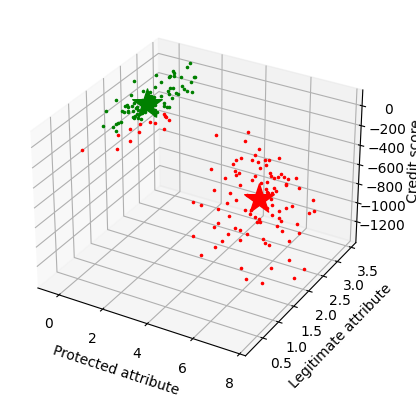

In [4]:
def plot_dfs(df1, df2, simple_or_complex):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  for df in [df1, df2]:
    for i in range(df.shape[0]):
      if df["Is real"].iloc[i] == 1:
        marko = "*"
        sizo = 500
      else:
        marko = "."
        sizo = 10
      if simple_or_complex == "simple":
        if df["Label simple"].iloc[i] > 0:
          colo = "green"
        else:
          colo = "red"
        ax.scatter(df["x1"].iloc[i], df["x2"].iloc[i], df["Label simple"].iloc[i], marker=marko, s=sizo, c=colo)
      else:
        if df["Label complex"].iloc[i] > 0:
          colo = "green"
        else:
          colo = "red"
        ax.scatter(df["x1"].iloc[i], df["x2"].iloc[i], df["Label complex"].iloc[i], marker=marko, s=sizo, c=colo)
  ax.set_xlabel('Protected attribute')
  ax.set_ylabel('Legitimate attribute')
  ax.set_zlabel('Credit score')
  plt.savefig(simple_or_complex+".jpg")
  plt.show()
  plt.close()
plot_dfs(cluster_0, cluster_1, "simple")

In [5]:
def perform_linreg(cluster, simple_or_complex):
  X = cluster[["x1", "x2"]].to_numpy()
  X = sm.add_constant(X)
  if simple_or_complex == "simple":
    print("Local approximation simple discriminator model")
    y = cluster[["Label simple"]].to_numpy()
  else:
    print("Local approximation complex discriminator model")
    y = cluster[["Label complex"]].to_numpy()
  mod = sm.OLS(y, X)
  res = mod.fit()
  print(res.summary())
  print(res.params[1])
  print(res.tvalues[1])
  print(res.rsquared)
  return res.params[1], res.tvalues[1], res.rsquared

simple_c0_x1, simple_c0_t, simple_c0_r2 = perform_linreg(cluster_0, "simple")
print()
simple_c1_x1, simple_c1_t, simple_c1_r2 = perform_linreg(cluster_1, "simple")


Local approximation simple discriminator model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1769.
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.26e-77
Time:                        07:34:10   Log-Likelihood:                -511.23
No. Observations:                 101   AIC:                             1028.
Df Residuals:                      98   BIC:                             1036.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

##Now analyzing complex discriminator model

In [6]:
##plot_dfs(cluster_0, cluster_1, "complex")

complex_c0_x1, complex_c0_t, complex_c0_r2 = perform_linreg(cluster_0, "complex")
print()
complex_c1_x1, complex_c1_t, complex_c1_r2 = perform_linreg(cluster_1, "complex")

Local approximation complex discriminator model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.2634
Date:                Mon, 22 Jan 2024   Prob (F-statistic):              0.769
Time:                        07:34:11   Log-Likelihood:                -717.02
No. Observations:                 101   AIC:                             1440.
Df Residuals:                      98   BIC:                             1448.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

In [7]:
print("Simple model:")
print("Coefficient of x1: ", end="")
print(str(round(simple_c0_x1, 2))+" "+str(round(simple_c1_x1,2)) )
print("t-values of coefficients of x1: ", end= "")
print(str(round(simple_c0_t, 2))+" "+str(round(simple_c1_t, 2)) )
print("R2-values of local models:")
print(str(round(simple_c0_r2,2))+" "+str(round(simple_c0_r2,2)))
print()
print("Dark model:")
print("Coefficient of x1: ", end="")
print(str(round(complex_c0_x1, 2))+" "+str(round(complex_c1_x1,2)) )
print("t-values of coefficients of x1: ", end= "")
print(str(round(complex_c0_t, 2))+" "+str(round(complex_c1_t, 2)) )
print("R2-values of local models:")
print(str(round(complex_c0_r2,2))+" "+str(round(complex_c0_r2,2)))


Simple model:
Coefficient of x1: -324.09 -13.03
t-values of coefficients of x1: -59.47 -14.77
R2-values of local models:
0.97 0.97

Dark model:
Coefficient of x1: -30.32 -0.07
t-values of coefficients of x1: -0.73 -0.11
R2-values of local models:
0.01 0.01


##Global explanation models.


In [8]:
population_cov = np.diag((2,2))*4
population = np.zeros(2).reshape(1,2)
while population.shape[0] < N+1:
  new = tim_generator.multivariate_normal(mean=population_mean, cov=population_cov, size=1)[0]
  if new[0] > 0 and new[1] > 0:
    population = np.concatenate((population, new.reshape(1,2)))
population = np.concatenate((x1.reshape(1,2), x2.reshape(1,2), population[1:,:]) )

simple_res = []
for i in range(population.shape[0]):
  simple_res.append(simple(population[i,:]) )
population = np.concatenate((population, np.array(simple_res).reshape(population.shape[0], 1) ), axis=1)
sample = tim_generator.integers(low=2, high=N, size=200)
sample = np.concatenate((np.array([0,1]), sample))
sample = population[sample,:]
print(sample.shape)

(202, 3)


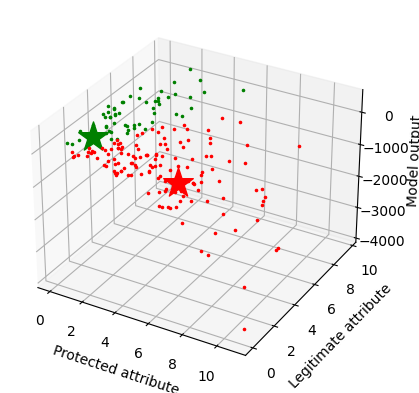

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(sample.shape[0]):
  if i in [0,1]:
    marko = "*"
    sizo = 500
  else:
    marko = "."
    sizo = 10
  if sample[i,2] > 0:
                    colo = "green"
  else:
                    colo = "red"
  ax.scatter(sample[i,0], sample[i,1], sample[i,2], c=colo, s=sizo, marker=marko)
##ax.set_xlim([0,50])
##ax.set_ylim([0,50])
ax.set_xlabel('Protected attribute')
ax.set_ylabel('Legitimate attribute')
ax.set_zlabel('Model output')
plt.savefig("simpleglobal.jpg")
plt.show()
plt.close()

In [10]:
X = sample[:,:2]
X = sm.add_constant(X)
y = sample[:,2]
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
print()
print("Linear approximation of global model")
print("Coefficient estimate of x1: ", end="")
print(round(res.params[1], 2))
print("t-value of coefficient estimate of x1: ", end="")
print(round(res.tvalues[1],2))
print("R2 of global model: ", end="")
print(round(res.rsquared,2))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     321.4
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           4.76e-63
Time:                        07:34:19   Log-Likelihood:                -1444.9
No. Observations:                 202   AIC:                             2896.
Df Residuals:                     199   BIC:                             2906.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        471.3473     52.023      9.060      0.0

##Analyzing for three fairness metrics.

This function takes as its input a sample where the columns are x1, x2 and credit score and returns and analysis of statistical parity and performance parity.

In [11]:
def make_df(sample):
  sample_df = pd.DataFrame(sample)
  sample_df.columns = ["x1", "x2", "Label simple"]
  return sample_df

def perform_t(sample_df):
  print("Number of elements: "+str(sample_df.index[-1]+1) )
  below_df = sample_df[sample_df["x1"] < population_mean[0]]
  below_df = below_df.reset_index()
  above_df = sample_df[sample_df["x1"] >= population_mean[0]]
  above_df = above_df.reset_index()
  print("Average credit score in sample of individuals with x1 below mean:"+str(round(np.average(below_df["Label simple"]),2)))
  print("Average credit score in sample of individuals with x1 above mean:"+str(round(np.average(above_df["Label simple"]),2)))
  t_res = stats.ttest_ind(above_df["Label simple"], below_df["Label simple"])
  print("The probability that these two averages are generated by the same distribution is: "+str(round(t_res.pvalue, 5)))
  print("The hypothesis that x1 does not impact credit scores is therefore ",end="")
  if t_res.pvalue < 0.05:
    print("rejected")
  else:
    print("not rejected")
  print("T-statistic is: "+str(round(t_res.statistic,2)))
  print("Confidence interval at 95 pct is: ")
  print(t_res.confidence_interval(confidence_level=0.95) )
  print()

def analyze_fairness(sample):
  print("Analyzing statistical parity: ")
  sample_df = make_df(sample)
  perform_t(sample_df)
  print("Analyzing performance parity: ")
  sample_df = make_df(sample)
  sample_df = sample_df[sample_df["x2"] >= population_mean[1] ]
  sample_df = sample_df.reset_index()
  print("Now only analyzing sample elements with x2 above mean. " )
  perform_t(sample_df)
  print()

analyze_fairness(sample)

Analyzing statistical parity: 
Number of elements: 202
Average credit score in sample of individuals with x1 below mean:42.52
Average credit score in sample of individuals with x1 above mean:-683.73
The probability that these two averages are generated by the same distribution is: 0.0
The hypothesis that x1 does not impact credit scores is therefore rejected
T-statistic is: -9.81
Confidence interval at 95 pct is: 
ConfidenceInterval(low=-872.2797388747792, high=-580.220515410826)

Analyzing performance parity: 
Now only analyzing sample elements with x2 above mean. 
Number of elements: 126
Average credit score in sample of individuals with x1 below mean:77.34
Average credit score in sample of individuals with x1 above mean:-700.75
The probability that these two averages are generated by the same distribution is: 0.0
The hypothesis that x1 does not impact credit scores is therefore rejected
T-statistic is: -8.97
Confidence interval at 95 pct is: 
ConfidenceInterval(low=-949.873636645953

##Simulating fairness gerrymandering.

In [12]:
def make_binary(arr):
  new_label = np.sign(arr[:,2])
  arr[:,2] = new_label
  return arr

population = make_binary(population)
sample = make_binary(sample)


In [13]:
print("Analyzing parity - credit scores are binary. Random sample 202 elements")
analyze_fairness(sample)

Analyzing parity - credit scores are binary. Random sample 202 elements
Analyzing statistical parity: 
Number of elements: 202
Average credit score in sample of individuals with x1 below mean:0.2
Average credit score in sample of individuals with x1 above mean:-0.93
The probability that these two averages are generated by the same distribution is: 0.0
The hypothesis that x1 does not impact credit scores is therefore rejected
T-statistic is: -10.93
Confidence interval at 95 pct is: 
ConfidenceInterval(low=-1.328176357239984, high=-0.922290932479642)

Analyzing performance parity: 
Now only analyzing sample elements with x2 above mean. 
Number of elements: 126
Average credit score in sample of individuals with x1 below mean:0.62
Average credit score in sample of individuals with x1 above mean:-0.87
The probability that these two averages are generated by the same distribution is: 0.0
The hypothesis that x1 does not impact credit scores is therefore rejected
T-statistic is: -12.73
Confide

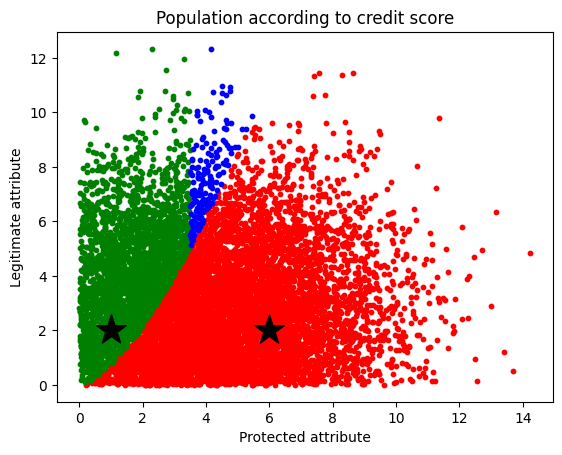

In [14]:
pop_df = pd.DataFrame(population)
pop_df.columns = ["x1", "x2", "Label"]
groups = []
for i in pop_df.index:
  if pop_df["Label"].iloc[i] < 0:
    g = 1
  elif pop_df["Label"].iloc[i] > 0 and pop_df["x1"].iloc[i] > population_mean[0]:
    g = 3
  else:
    g = 2
  groups.append(g)
pop_df["Group"] = pd.Series(groups)
df_list = []
for g in [1,2,3]:
  df = pop_df[pop_df["Group"] == g]
  df = df.reset_index()
  df_list.append(df)
colos = ["red", "green", "blue"]
for i in range(3):
  df = df_list[i]
  plt.scatter(df["x1"], df["x2"], c=colos[i], s= 10)
plt.scatter(x1[0], x1[1], c="black", s=500, marker="*")
plt.scatter(x2[0], x2[1], c="black", s=500, marker="*")
plt.xlabel("Protected attribute")
plt.ylabel("Legitimate attribute")
plt.title("Population according to credit score")
plt.savefig("Gerrymander.jpg")
plt.show()
plt.close()

In [15]:
print("Now analyzing the gerrymandered sample of 202 random obsevations and 180 observations from select demographic (blue)")
sg = df_list[2]
sg = sg[["x1", "x2", "Label"]]
gerry_sample = np.concatenate((sample, sg.to_numpy() ) )
analyze_fairness(gerry_sample)

Now analyzing the gerrymandered sample of 202 random obsevations and 180 observations from select demographic (blue)
Analyzing statistical parity: 
Number of elements: 382
Average credit score in sample of individuals with x1 below mean:0.2
Average credit score in sample of individuals with x1 above mean:0.28
The probability that these two averages are generated by the same distribution is: 0.47295
The hypothesis that x1 does not impact credit scores is therefore not rejected
T-statistic is: 0.72
Confidence interval at 95 pct is: 
ConfidenceInterval(low=-0.1428269284232578, high=0.3072868587368467)

Analyzing performance parity: 
Now only analyzing sample elements with x2 above mean. 
Number of elements: 306
Average credit score in sample of individuals with x1 below mean:0.62
Average credit score in sample of individuals with x1 above mean:0.52
The probability that these two averages are generated by the same distribution is: 0.37855
The hypothesis that x1 does not impact credit score